In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
stock_data = pd.read_csv('source\dfnew_clean.csv')
stock_data["FutureOne"]= stock_data.Close.shift(-1)
stock_data["FutureThree"]= stock_data.Close.shift(-3)
stock_data["FutureFive"]= stock_data.Close.shift(-5)
stock_data.dropna()

,DateTime,Volume,Transaction,Open,High,Low,Close,Dir,Change,ForeignBuy,ForeignSell,ForeignNet,TrustBuy,TrustSell,TrustNet,DealerNet,DealerBuy,DealerSell,InvestorsNet,PE-Ratio,PBR,Yield,ForeignVol,TrustVol,DealerVol,InvestorsVol,Pattern,Trend,InvestorsNet_Dir,ForeignNet_Dir,TrustNet_Dir,DealerNet_Dir,Dir2,FutureOne,FutureThree,FutureFive
0,2013-01-02,40647,14353,97.6,99.9,97.1,99.6,+,2.6,22484,8625,13859,1746,147,1599,-350,1300,1650,15108,16.54,3.83,3.01,31109,1893,2950,35952,0,0,1,1,1,0,0,101.0,100.5,100.0
1,2013-01-03,44335,12616,100.5,102.0,100.0,101.0,+,1.4,32303,17347,14955,926,516,410,-1067,1512,2579,14298,16.78,3.88,2.97,49651,1442,4091,55184,0,0,1,1,1,0,1,101.5,99.7,101.0
2,2013-01-04,39502,10276,100.5,101.5,100.0,101.5,+,0.5,33581,24337,9244,234,190,44,-246,910,1156,9042,16.86,3.90,2.96,57919,424,2066,60409,0,0,1,1,1,0,1,100.5,100.0,101.0
3,2013-01-07,42328,9042,101.0,101.0,99.1,100.5,-,1.0,26613,26952,-339,203,925,-722,-450,871,1321,-1511,16.69,3.86,2.99,53565,1128,2192,56885,0,0,0,0,0,0,2,99.7,101.0,102.0
4,2013-01-08,31218,9463,99.6,100.0,98.9,99.7,-,0.8,16628,15087,1540,209,635,-426,-80,749,829,1034,16.56,3.83,3.01,31715,844,1578,34137,0,0,1,1,0,0,2,100.0,101.0,100.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2022-12-19,24231,30247,466.5,469.5,465.0,466.5,-,4.5,14328,17346,-3017,565,206,359,-1075,212,1287,-3733,13.64,4.42,2.36,31674,771,1499,33944,0,0,0,0,1,0,2,457.5,468.0,456.5
2443,2022-12-20,33181,59543,465.0,467.0,455.0,457.5,-,9.0,11840,19861,-8021,655,21,633,-1251,341,1592,-8638,13.38,4.33,2.40,31701,676,1933,34310,0,0,0,0,1,0,2,459.0,455.0,457.0
2444,2022-12-21,40831,31581,460.0,463.0,457.0,459.0,+,1.5,32181,31770,410,578,991,-413,-1033,465,1498,-1035,13.42,4.35,2.40,63951,1569,1963,67484,6,0,0,1,0,0,1,468.0,456.5,451.0
2445,2022-12-22,14519,16893,466.5,469.0,464.0,468.0,+,9.0,8931,5839,3091,576,2,574,-286,214,501,3378,13.68,4.43,2.35,14771,578,715,16064,0,2,1,1,1,0,1,455.0,457.0,446.0


In [3]:
target = ['FutureFive']
features = ['Transaction','Open', 'High', 'Low','Change','TrustNet','InvestorsNet','Close']
df = stock_data[features + target]

In [4]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])

# extract the input sequences and output values
sequence_length = 5

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape)
print(X_test.shape)

(1956, 5, 9)
(486, 5, 9)


In [5]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=200, activation="tanh", return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=50))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             12000     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 73,421
Trainable params: 73,421
Non-traina

In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
model.save('save\LSTM_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
31/31 [==============================] - 3s 8ms/step - loss: 0.0129
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 9.1613e-04
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 9.0941e-04
Epoch 8/50
31/31 [==============================] - 0s 8ms/step - loss: 8.5306e-04
Epoch 9/50
31/31 [==============================] - 0s 8ms/step - loss: 8.1309e-04
Epoch 10/50
31/31 [==============================] - 0s 8ms/step - loss: 8.0861e-04
Epoch 11/50
31/31 [==============================] - 0s 7ms/step - loss: 6.7816e-04
Epoch 12/50
31/31 [==============================] - 0s 7ms/step - loss: 8.0326e-04
Epoch 13/50
31/31 [==

In [7]:
# plot the test set predictions
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
# plot=df[['Close', 'Predicted Close']].plot()
# fig = plot.get_figure()
# fig.savefig("multi_intput_LSTM_model_eps32_bsize64.png")
res=pd.concat([stock_data['DateTime'],df],axis=1)
test=res[['DateTime','Open','Close', 'Predicted']].dropna().reset_index(drop=True)
test

,DateTime,Open,Close,Predicted
0,2021-01-08,580.0,580.0,588.365356
1,2021-01-11,577.0,584.0,592.144409
2,2021-01-12,583.0,591.0,596.177368
3,2021-01-13,595.0,605.0,603.074036
4,2021-01-14,587.0,592.0,607.850464
...,...,...,...,...
477,2022-12-20,465.0,457.5,465.413147
478,2022-12-21,460.0,459.0,464.682281
479,2022-12-22,466.5,468.0,465.897003
480,2022-12-23,457.5,455.0,460.872131


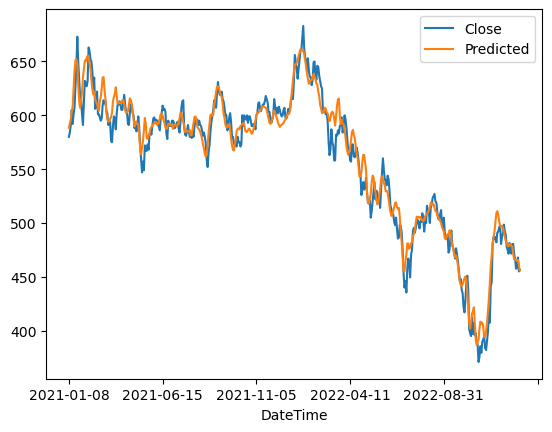

In [8]:
plot=test.plot(x='DateTime',y=['Close','Predicted'])
fig = plot.get_figure()
fig.savefig("save\LSTM_eps32_bsize64.png")

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

test.loc[test.Predicted.shift(1) >= test.Predicted, "PredTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Predicted, "PredTrend"]= 1
test['PredTrend']=test['PredTrend'].fillna(0).astype(int)


test['status'] = test.PredTrend.shift(1).fillna(0).astype(int)

# .shift(1)是前一個

test['buy_cost'] = test.Open[np.where((test.status == 1) * (test.status.shift(1) == 0))[0]]
test['sell_cost'] = test.Open[np.where((test.status == 0) * (test.status.shift(1) == 1))[0]]

test = test.fillna(0)
buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1
fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.Open / test.Open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

test

,DateTime,Open,Close,Predicted,PredTrend,status,buy_cost,sell_cost,trade_ret,net_trade_ret,open_ret,strategy_ret,strategy_net_ret,buy_and_hold_equity,strategy_equity,strategy_net_equity
0,2021-01-08,580.0,580.0,588.365356,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,2021-01-11,577.0,584.0,592.144409,1,0,0.0,0.0,0.000000,0.000000,-0.005172,-0.000000,-0.000000,0.994828,1.000000,1.000000
2,2021-01-12,583.0,591.0,596.177368,1,1,583.0,0.0,0.000000,0.000000,0.010399,0.000000,0.000000,1.005172,1.000000,1.000000
3,2021-01-13,595.0,605.0,603.074036,1,1,0.0,0.0,0.000000,0.000000,0.020583,0.020583,0.020583,1.025862,1.020583,1.020583
4,2021-01-14,587.0,592.0,607.850464,1,1,0.0,0.0,0.000000,0.000000,-0.013445,-0.013445,-0.013445,1.012069,1.006861,1.006861
5,2021-01-15,621.0,601.0,623.722473,1,1,0.0,0.0,0.000000,0.000000,0.057922,0.057922,0.057922,1.070690,1.065180,1.065180
6,2021-01-18,608.0,607.0,641.026489,1,1,0.0,0.0,0.000000,0.000000,-0.020934,-0.020934,-0.020934,1.048276,1.042882,1.042882
7,2021-01-19,618.0,627.0,651.192688,1,1,0.0,0.0,0.000000,0.000000,0.016447,0.016447,0.016447,1.065517,1.060034,1.060034
8,2021-01-20,633.0,647.0,652.065552,1,1,0.0,0.0,0.000000,0.000000,0.024272,0.024272,0.024272,1.091379,1.085763,1.085763
9,2021-01-21,640.0,673.0,647.112976,0,1,0.0,0.0,0.000000,0.000000,0.011058,0.011058,0.011058,1.103448,1.097770,1.097770


Text(0, 0.5, 'strategy_net_equity')

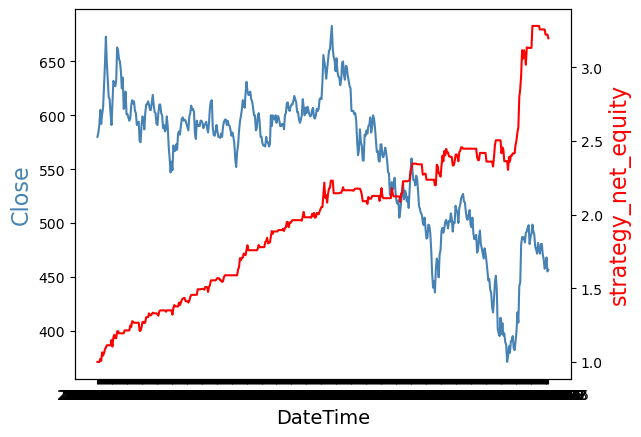

In [10]:
import matplotlib.pyplot as plt
col1 = 'steelblue'
col2 = 'red'
col3 = 'green'
fig2,ax = plt.subplots()
ax.plot(test.DateTime, test.Close, color=col1)
ax.set_xlabel('DateTime', fontsize=14)
ax.set_ylabel('Close', color=col1, fontsize=16)
ax2 = ax.twinx()
ax2.plot(test.DateTime, test.strategy_equity, color=col2)
ax2.set_ylabel('strategy_net_equity', color=col2, fontsize=16)

In [11]:
dfpred=test[['DateTime','Open','Close', 'Predicted']].dropna().reset_index(drop=True)
# dfpred.to_csv('source/pred3.csv', encoding='utf-8',index=None)